# Voice Recognition for Harry Potter Spells

This notebook implements the Professor Dumbledore challenge: creating an AI for voice recognition of at least 8 magical spells from Harry Potter.

## Import Libraries

In [1]:
import os
import numpy as np
import speech_recognition as sr
from gtts import gTTS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import librosa
import glob

## Define Spells

In [2]:
spells = [
    'Avada Kedavra',
    'Expecto Patronum', 
    'Lumos',
    'Nox',
    'Wingardium Leviosa',
    'Accio',
    'Expelliarmus',
    'Stupefy'
]

## Generate Audio Dataset

In [3]:
# Create audio directory
audio_dir = '../datasets/audio'
os.makedirs(audio_dir, exist_ok=True)

# Define languages and TLDs for different voices
languages = ['en', 'fr']
tlds = {
    'en': ['com', 'co.uk', 'com.au'],
    'fr': ['fr', 'com']
}

# Generate audio for each spell with different language/TLD combinations
for spell in spells:
    for lang in languages:
        for tld in tlds.get(lang, []):
            try:
                tts = gTTS(text=spell, lang=lang, tld=tld)
                filename = f"{audio_dir}/{spell.replace(' ', '_')}_{lang}_{tld}.mp3"
                tts.save(filename)
                print(f"Generated {filename}")
            except Exception as e:
                print(f"Failed to generate {spell} for {lang}/{tld}: {e}")

Generated ../datasets/audio/Avada_Kedavra_en_com.mp3
Generated ../datasets/audio/Avada_Kedavra_en_co.uk.mp3
Generated ../datasets/audio/Avada_Kedavra_en_co.uk.mp3
Generated ../datasets/audio/Avada_Kedavra_en_com.au.mp3
Generated ../datasets/audio/Avada_Kedavra_en_com.au.mp3
Generated ../datasets/audio/Avada_Kedavra_fr_fr.mp3
Generated ../datasets/audio/Avada_Kedavra_fr_com.mp3
Generated ../datasets/audio/Avada_Kedavra_fr_fr.mp3
Generated ../datasets/audio/Avada_Kedavra_fr_com.mp3
Generated ../datasets/audio/Expecto_Patronum_en_com.mp3
Generated ../datasets/audio/Expecto_Patronum_en_com.mp3
Generated ../datasets/audio/Expecto_Patronum_en_co.uk.mp3
Generated ../datasets/audio/Expecto_Patronum_en_com.au.mp3
Generated ../datasets/audio/Expecto_Patronum_en_co.uk.mp3
Generated ../datasets/audio/Expecto_Patronum_en_com.au.mp3
Generated ../datasets/audio/Expecto_Patronum_fr_fr.mp3
Generated ../datasets/audio/Expecto_Patronum_fr_com.mp3
Generated ../datasets/audio/Expecto_Patronum_fr_fr.mp3
Gen

## Feature Extraction

In [4]:
def extract_features(file_path):
    # Load audio with librosa (supports MP3 and WAV)
    audio, sample_rate = librosa.load(file_path, sr=16000)
    # Convert to int16 for speech_recognition
    audio_int = (audio * 32767).astype(np.int16)
    # Create AudioData
    audio_data = sr.AudioData(audio_int.tobytes(), 16000, 2)
    # Recognize
    try:
        text = sr.Recognizer().recognize_google(audio_data)
        return text.lower().strip()
    except (sr.UnknownValueError, sr.RequestError):
        return ""

# Extract features for all audio files
features = []
labels = []

for file_path in glob.glob(f"{audio_dir}/*.mp3") + glob.glob(f"{audio_dir}/*.wav"):
    filename = os.path.basename(file_path)
    # Extract spell from filename (e.g., Avada_Kedavra_en_com.mp3 -> Avada Kedavra)
    parts = filename.replace('.mp3', '').replace('.wav','').split('_')
    # If file uses manual naming with suffixes, try to strip lang/tld if present
    if len(parts) > 2 and parts[-1] in ['com','fr','co.uk','com.au']:
        spell = ' '.join(parts[:-2])
    elif len(parts) > 1 and parts[-1].startswith('manual'):
        spell = ' '.join(parts[:-1])
    else:
        spell = ' '.join(parts[:-2]) if len(parts) > 2 else ' '.join(parts[:-1])

    text = extract_features(file_path)
    if text:  # Only add if recognition succeeded
        features.append(text)
        labels.append(spell)

print(f"Extracted features for {len(features)} audio samples")

# Vectorize the text features
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(features).toarray()
y = np.array(labels)

Extracted features for 38 audio samples


## Prepare Dataset

In [5]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

## Build Model

In [6]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(spells), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/Users/nimzero/Dev/Cours/Workshop/group2/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,560 (154.53 KB)

 Trainable params: 39,560 (154.53 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [7]:
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1667 - loss: 2.0733 - val_accuracy: 0.1250 - val_loss: 2.0377
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1667 - loss: 2.0733 - val_accuracy: 0.1250 - val_loss: 2.0377
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2667 - loss: 2.0069 - val_accuracy: 0.3750 - val_loss: 2.0052
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2667 - loss: 2.0069 - val_accuracy: 0.3750 - val_loss: 2.0052
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4333 - loss: 1.9485 - val_accuracy: 0.3750 - val_loss: 1.9700
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4333 - loss: 1.9485 - val_accuracy: 0.3750 - val_loss: 1.9700
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5333 - loss: 1.8948 - val_accuracy: 0.3750 - val_loss: 1.9278
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5333 - loss: 1.8948 - val_accuracy: 0.3750 - val_loss: 1.9278
Epoc

## Evaluate Model

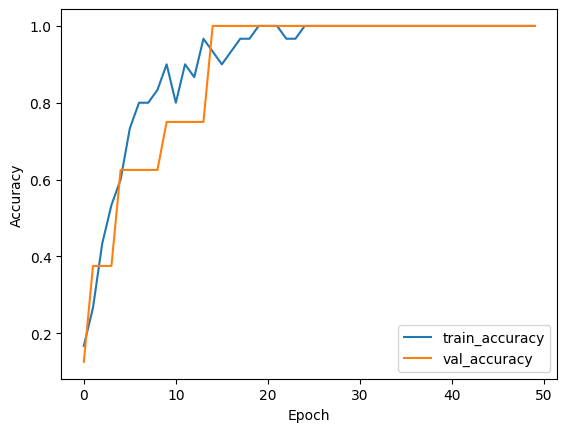

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0245
Test Loss: 0.024461081251502037, Test Accuracy: 1.0
Test Loss: 0.024461081251502037, Test Accuracy: 1.0


In [8]:
# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Save model
# Use native Keras format (.keras) instead of legacy HDF5
model.save('../models/spell_recognition_model.keras')

## Enregistrer vos propres échantillons (microphone)

Utilisez le microphone pour enregistrer des échantillons audio que vous pouvez ajouter au dossier `datasets/audio/` pour enrichir l'entraînement.
Les enregistrements seront sauvegardés au format WAV. Assurez-vous d'avoir `PyAudio` ou un backend compatible installé pour l'accès au microphone via `speech_recognition`.

In [11]:
import time
import tempfile
import wave

def record_sample_microphone(spell, duration=3, filename=None, sample_rate=16000):
    """Record from the default microphone and save a WAV file.
    Parameters:
      spell: label/name of the spell (used in default filename)
      duration: seconds to record (phrase_time_limit)
      filename: optional path to save the WAV file
    Returns: path to saved WAV file
    """
    r = sr.Recognizer()
    try:
        with sr.Microphone(sample_rate=sample_rate) as source:
            print(f"Adjusting for ambient noise...")
            r.adjust_for_ambient_noise(source, duration=0.5)
            print(f"Recording for '{spell}' (max {duration}s). Please speak now...")
            audio = r.listen(source, phrase_time_limit=duration)
    except Exception as e:
        print('Microphone recording failed:', e)
        return None

    # Get WAV bytes and write to file
    wav_bytes = audio.get_wav_data(convert_rate=sample_rate, convert_width=2)
    if filename is None:
        safe_name = spell.replace(' ', '_')
        filename = os.path.join(audio_dir, f"{safe_name}_manual_{int(time.time())}.wav")
    try:
        with open(filename, 'wb') as f:
            f.write(wav_bytes)
        print('Saved', filename)
        return filename
    except Exception as e:
        print('Failed to save WAV file:', e)
        return None

def record_for_spell(spell, n=3, duration=3):
    "Record n samples for a given spell and save them to the audio directory."
    saved = []
    for i in range(n):
        print(f'[{i+1}/{n}] Prepare to record for "{spell}"')
        p = record_sample_microphone(spell, duration=duration)
        if p:
            saved.append(p)
        time.sleep(0.5)
    print(f'Recorded {len(saved)} files for {spell}')
    return saved

# Example usage (uncomment to use):
# record_for_spell('Avada Kedavra', n=3, duration=2)

## Reconnaissance en direct (microphone)

Utilisez le modèle entraîné pour reconnaître un sort dit au microphone. Ce cell suppose que `vectorizer`, `model` et `le` (LabelEncoder) sont en mémoire (exécutez les cellules précédentes si nécessaire).

In [12]:
import tempfile

def recognize_from_microphone(duration=3):
    "Record from microphone, transcribe, vectorize and predict the spell using the trained model."
    # Ensure prerequisites are available
    missing = []
    for v in ['vectorizer', 'model', 'le']:
        if v not in globals():
            missing.append(v)
    if missing:
        print('Missing required objects in memory:', missing)
        print('Please run the training cells to create vectorizer, model and le.')
        return None

    # Record a short sample to a temp file
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
    tmp_name = tmp.name
    tmp.close()
    p = record_sample_microphone('live_sample', duration=duration, filename=tmp_name)
    if not p:
        print('Recording failed; cannot recognize')
        return None

    # Extract text (uses the same extract_features function defined earlier)
    text = extract_features(tmp_name)
    if not text:
        print('Speech could not be transcribed reliably')
        return None
    X_live = vectorizer.transform([text]).toarray()
    probs = model.predict(X_live)
    idx = int(np.argmax(probs, axis=1)[0])
    predicted = le.inverse_transform([idx])[0]
    print(f'Predicted spell: {predicted} (text: "{text}")')
    return predicted

# Example usage (uncomment to use):
recognize_from_microphone(duration=3)

Microphone recording failed: Could not find PyAudio; check installation
Recording failed; cannot recognize
